## Computer Vision Assignment 2

Priyansh Khunger

2020101056

In [298]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision

In [299]:
# suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [300]:
# downloading the MNIST dataset
from torchvision import datasets
from torchvision import transforms

# define transformation to apply to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the data
])

# Download and load the training set
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Download and load the test set
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [301]:
# defining a function to convert tensor to array and display image
def tensor_to_array(tensor_input, display = True):
    array = tensor_input.numpy()
    i = array.reshape(array.shape[1:])
    if display:
        plt.imshow(i, cmap='gray')
    return array

The index of image is : 57509
The label of image is : 2
The shape of the image is: (1, 28, 28)


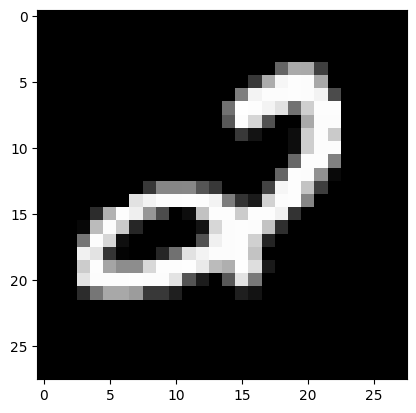

In [302]:
# showing a random picture from the dataset
length_train = len(train_set)
index = np.random.randint(length_train-1)
tensor1, label1 = train_set[index]
array1 = tensor_to_array(tensor1)
print("The index of image is :" , index)
print("The label of image is :" , label1)
print("The shape of the image is:" , array1.shape)

### SIFT-BoVW-SVM

#### Implementing SIFT detector and descriptor

In [303]:
# defining functions to detect, describe and draw keypoints

def sift_func(tensor_input, display = True):
    array1= tensor_to_array(tensor_input= tensor_input, display= False)
    image8bit = cv2.normalize(array1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8').squeeze()
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image8bit, None)

    if display:
        img = cv2.drawKeypoints(image8bit, keypoints, array1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img)

    return keypoints, descriptors



<class 'tuple'>


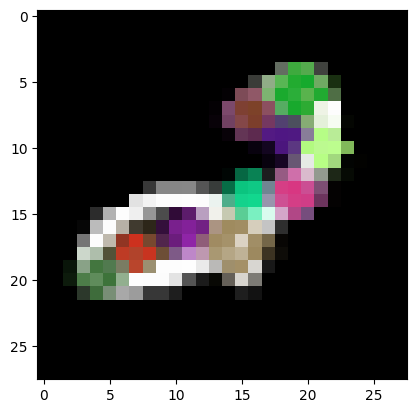

In [304]:
# running the function
o1 = sift_func(tensor1)
print(type(o1))

In [305]:
# running the function on the train set
train_features = []

for i in range(length_train):
    tensor, label = train_set[i]
    keypoints, descriptors = sift_func(tensor, display= False)
    train_features.append(descriptors)
    print(i+1, "done out of", length_train , end = "\r")
print("The length of train features is:", len(train_features))

The length of train features is: 60000


In [306]:
# combining the features into one list

train_features_combined = []
for i in range(len(train_features)):
    if train_features[i] is not None: # to avoid the none type
        for j in range(len(train_features[i])):
            train_features_combined.append(train_features[i][j])

print("The length of combined train features set is:", len(train_features_combined))

# changing the list to matrix
train_features_matrix = np.array(train_features_combined)
print("The shape of the train features matrix is:", train_features_matrix.shape)

The length of combined train features set is: 468148
The shape of the train features matrix is: (468148, 128)


In [307]:
# performing the clustering
from sklearn.cluster import KMeans

k = 100
kmeans = KMeans(n_clusters=k, random_state=1).fit(train_features_matrix)
centroids = kmeans.cluster_centers_
print("The shape of the centroids is:", centroids.shape)


The shape of the centroids is: (100, 128)


In [308]:
# turning into histogram
im_features=np.zeros((len(train_set),k),"float32")
for i in range(len(train_set)):
    if train_features[i] is not None:
        words = kmeans.predict(train_features[i])
        for w in words:
            im_features[i][w]+=1

The shape of the image features is: (60000, 100)


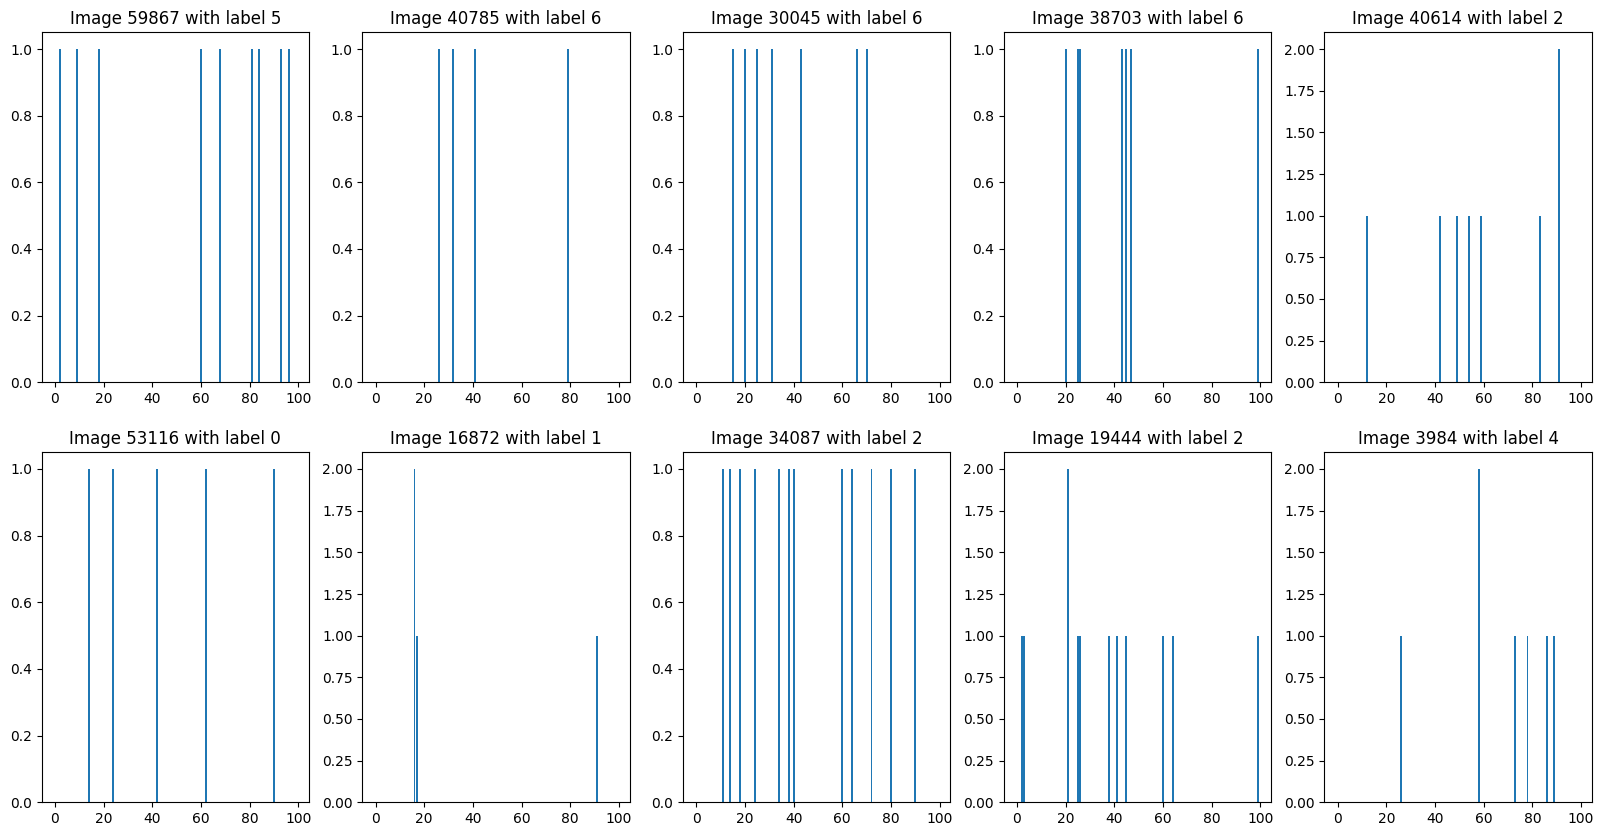

In [309]:
# representing the image as a histogram of visual words
print("The shape of the image features is:", im_features.shape)

# making a histogram of the visual words
# making a list of random index to display
index_list = np.random.randint(length_train, size = 10)

plt.figure(figsize=(20, 10))    
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.bar(range(k), im_features[index_list[i]])
    plt.title("Image " + str(index_list[i]) + " with label " + str(train_set[index_list[i]][1]))
plt.show()

In [310]:
# doing the linear classification using SVMs
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(im_features, [x[1] for x in train_set])
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=1, tol=0.0001, verbose=0)

LinearSVC(dual=True, random_state=1)

In [311]:
# running on test set
length_test = len(test_set)
test_features = []

for i in range(length_test):
    tensor, label = test_set[i]
    keypoints, descriptors = sift_func(tensor, display= False)
    test_features.append(descriptors)
    print(i+1, "done out of", length_test , end = "\r")

print("The length of test features is:", len(test_features))

im_features_test=np.zeros((len(test_set),k),"float32")
for i in range(len(test_set)):
    if test_features[i] is not None:
        words = kmeans.predict(test_features[i])
        for w in words:
            im_features_test[i][w]+=1
            


# making predictions
predictions = classifier.predict(im_features_test)

# calculating accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score([x[1] for x in test_set], predictions)
print("The accuracy of the model is:", accuracy)


The length of test features is: 10000
The accuracy of the model is: 0.7347


#### Hyperparameter tuning of cluster center numbers

In [312]:
# entire pipeline from start to finish, SIFT, BoVW and SVM

def BoVW_SVM(cluster_centers):
    # running the function on the train set
    print("Training has started")
    train_features = []

    for i in range(length_train):
        tensor, label = train_set[i]
        keypoints, descriptors = sift_func(tensor, display= False)
        train_features.append(descriptors)
        print(i+1, "done out of", length_train , end = "\r")
    print("The length of train features is:", len(train_features))

    #  combining the features into one list

    train_features_combined = []
    for i in range(len(train_features)):
        if train_features[i] is not None: # to avoid the none type
            for j in range(len(train_features[i])):
                train_features_combined.append(train_features[i][j])

    print("The length of combined train features set is:", len(train_features_combined))

    # changing the list to matrix
    train_features_matrix = np.array(train_features_combined)
    print("The shape of the train features matrix is:", train_features_matrix.shape)

    # performing the clustering
    from sklearn.cluster import KMeans

    k = cluster_centers
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_features_matrix)
    centroids = kmeans.cluster_centers_
    print("The shape of the centroids is:", centroids.shape)


    im_features=np.zeros((len(train_set),k),"float32")
    for i in range(len(train_set)):
        if train_features[i] is not None:
            words = kmeans.predict(train_features[i])
            for w in words:
                im_features[i][w]+=1

    # representing the image as a histogram of visual words
    print("The shape of the image features is:", im_features.shape)

    # doing the linear classification using SVMs
    from sklearn.svm import LinearSVC
    classifier = LinearSVC()
    classifier.fit(im_features, [x[1] for x in train_set])
    LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=1, tol=0.0001, verbose=0)

    print("Testing has started")
    # running on test set
    length_test = len(test_set)
    test_features = []

    for i in range(length_test):
        tensor, label = test_set[i]
        keypoints, descriptors = sift_func(tensor, display= False)
        test_features.append(descriptors)
        print(i+1, "done out of", length_test , end = "\r")

    print("The length of test features is:", len(test_features))

    im_features_test=np.zeros((len(test_set),k),"float32")
    for i in range(len(test_set)):
        if test_features[i] is not None:
            words = kmeans.predict(test_features[i])
            for w in words:
                im_features_test[i][w]+=1


    # making predictions
    predictions = classifier.predict(im_features_test)

    # calculating accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score([x[1] for x in test_set], predictions)
    print("The accuracy of the model, with " , cluster_centers, " is:", accuracy)


In [313]:
# showing it
BoVW_SVM(100)

Training has started
The length of train features is: 60000
The length of combined train features set is: 468148
The shape of the train features matrix is: (468148, 128)
The shape of the centroids is: (100, 128)
The shape of the image features is: (60000, 100)
Testing has started
The length of test features is: 10000
The accuracy of the model, with  100  is: 0.7345


In [314]:
# function which takes in train_features_matrix and then performs BoVW and SVM

import time

def BoVW_SVM_2(train_features_matrix, cluster_centers):
    # performing the clustering
    start_time = time.time()
    from sklearn.cluster import KMeans

    k = cluster_centers
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_features_matrix)
    centroids = kmeans.cluster_centers_
    
    # print("The shape of the centroids is:", centroids.shape)


    im_features=np.zeros((len(train_set),k),"float32")
    for i in range(len(train_set)):
        if train_features[i] is not None:
            words = kmeans.predict(train_features[i])
            for w in words:
                im_features[i][w]+=1
    # representing the image as a histogram of visual words
    # print("The shape of the image features is:", im_features.shape)

    # doing the linear classification using SVMs
    from sklearn.svm import LinearSVC
    classifier = LinearSVC()
    classifier.fit(im_features, [x[1] for x in train_set])
    LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=1, tol=0.0001, verbose=0)

    # print("Testing has started")

    # running on test set
    length_test = len(test_set)
    test_features = []

    for i in range(length_test):
        tensor, label = test_set[i]
        keypoints, descriptors = sift_func(tensor, display= False)
        test_features.append(descriptors)
        # print(i+1, "done out of", length_test , end = "\r")

    # print("The length of test features is:", len(test_features))

    im_features_test=np.zeros((len(test_set),k),"float32")
    for i in range(len(test_set)):
        if test_features[i] is not None:
            words = kmeans.predict(test_features[i])
            for w in words:
                im_features_test[i][w]+=1


    # making predictions
    predictions = classifier.predict(im_features_test)

    # calculating accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score([x[1] for x in test_set], predictions)
    print("The accuracy of the model, with " , cluster_centers, " is:", accuracy)
    end_time = time.time()
    total_time = end_time - start_time
    return accuracy, total_time

In [315]:
# showing it
BoVW_SVM_2(train_features_matrix, 100)

The accuracy of the model, with  100  is: 0.7345


(0.7345, 71.89796018600464)

In [316]:
# hyperparameter tuning of cluster center numbers
cluster_centers = [10,20,50,100,200,500]
accuracy = []
time_taken = []

for i in cluster_centers:
    acc , time_take = BoVW_SVM_2(train_features_matrix, i)
    accuracy.append(acc)
    time_taken.append(time_take)


The accuracy of the model, with  10  is: 0.3782
The accuracy of the model, with  20  is: 0.5072
The accuracy of the model, with  50  is: 0.6472
The accuracy of the model, with  100  is: 0.735
The accuracy of the model, with  200  is: 0.794
The accuracy of the model, with  500  is: 0.8387


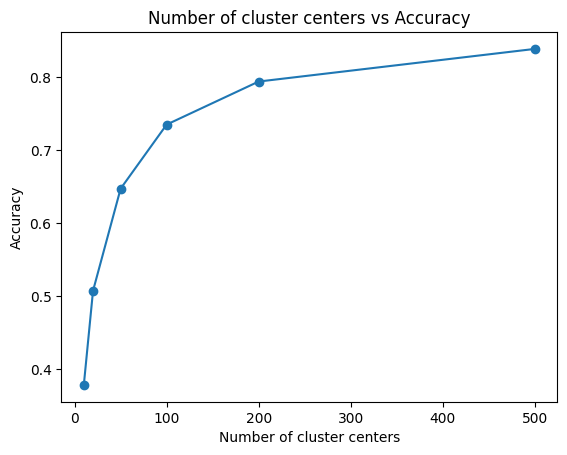

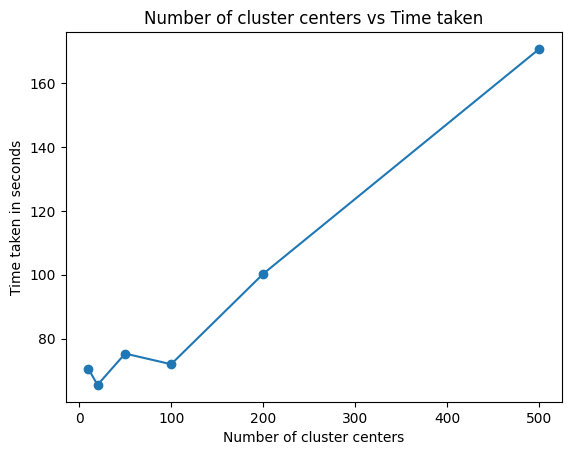

In [320]:
# plotting graphs
plt.plot(cluster_centers, accuracy, '-o')
plt.xlabel('Number of cluster centers')
plt.ylabel('Accuracy')
plt.title('Number of cluster centers vs Accuracy')
plt.show()

plt.plot(cluster_centers, time_taken, '-o')
plt.xlabel('Number of cluster centers')
plt.ylabel('Time taken in seconds')
plt.title('Number of cluster centers vs Time taken')
plt.show()


As the number of clusters centers increases, the accuracy increases. When there were lesser centers, features were accumulated into same clusters. More centers allow for more distinguishability

#### Hyperparameter tuning of SIFT and Linear SVM

In [347]:
# we shall perform hypertuning in SIFT function
def sift_func1(tensor_input, display = True, nfeatures = 100, nOctaveLayers = 3):
    array1= tensor_to_array(tensor_input= tensor_input, display= False)
    image8bit = cv2.normalize(array1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8').squeeze()
    sift = cv2.SIFT_create(nfeatures, nOctaveLayers)
    keypoints, descriptors = sift.detectAndCompute(image8bit, None)

    if display:
        img = cv2.drawKeypoints(image8bit, keypoints, array1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img)

    return keypoints, descriptors

# changing the function to include nfeatures and nOctaveLayers

# entire pipeline from start to finish, SIFT, BoVW and SVM

def BoVW_SVM_SIFT(cluster_centers, nfeatures1, nOctaveLayers1):
    # running the function on the train set
    print("Training has started")
    train_features = []

    for i in range(length_train):
        tensor, label = train_set[i]
        keypoints, descriptors = sift_func1(tensor, display= False, nfeatures = nfeatures1, nOctaveLayers = nOctaveLayers1)
        train_features.append(descriptors)
        # print(i+1, "done out of", length_train , end = "\r")
    # print("The length of train features is:", len(train_features))

    #  combining the features into one list

    train_features_combined = []
    for i in range(len(train_features)):
        if train_features[i] is not None: # to avoid the none type
            for j in range(len(train_features[i])):
                train_features_combined.append(train_features[i][j])

    # print("The length of combined train features set is:", len(train_features_combined))

    # changing the list to matrix
    train_features_matrix = np.array(train_features_combined)
    # print("The shape of the train features matrix is:", train_features_matrix.shape)

    # performing the clustering
    from sklearn.cluster import KMeans

    k = cluster_centers
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_features_matrix)
    centroids = kmeans.cluster_centers_
    # print("The shape of the centroids is:", centroids.shape)


    im_features=np.zeros((len(train_set),k),"float32")
    for i in range(len(train_set)):
        if train_features[i] is not None:
            words = kmeans.predict(train_features[i])
            for w in words:
                im_features[i][w]+=1

    # representing the image as a histogram of visual words
    # print("The shape of the image features is:", im_features.shape)

    # doing the linear classification using SVMs
    from sklearn.svm import LinearSVC
    classifier = LinearSVC()
    classifier.fit(im_features, [x[1] for x in train_set])
    LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=1, tol=0.0001, verbose=0)

    print("Testing has started")
    # running on test set
    length_test = len(test_set)
    test_features = []

    for i in range(length_test):
        tensor, label = test_set[i]
        keypoints, descriptors = sift_func1(tensor, display= False, nfeatures = nfeatures1, nOctaveLayers = nOctaveLayers1)
        test_features.append(descriptors)
        # print(i+1, "done out of", length_test , end = "\r")

    # print("The length of test features is:", len(test_features))

    im_features_test=np.zeros((len(test_set),k),"float32")
    for i in range(len(test_set)):
        if test_features[i] is not None:
            words = kmeans.predict(test_features[i])
            for w in words:
                im_features_test[i][w]+=1


    # making predictions
    predictions = classifier.predict(im_features_test)

    # calculating accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score([x[1] for x in test_set], predictions)
    print("The accuracy of the model, with " , cluster_centers, " SIFT nfeatures", nfeatures1 , " SIFT nOctave layers" , nOctaveLayers1,  " is:", accuracy)



In [348]:
# hypertuning

# case 1: decreasing the number of best features to be retained, Default is 100
BoVW_SVM_SIFT(100, nfeatures1= 5, nOctaveLayers1=3)

# case 2: increasing the number of octave layers (the number of scales to be seen at) , default is 3.
BoVW_SVM_SIFT(100, nfeatures1= 100, nOctaveLayers1=9)

# case 3: increasing the number of octave layers (the number of scales to be seen at) , and keeping nfeatures 50
BoVW_SVM_SIFT(100, nfeatures1= 50, nOctaveLayers1=6)

Training has started
Testing has started
The accuracy of the model, with  100  SIFT nfeatures 5  SIFT nOctave layers 3  is: 0.6718
Training has started
Testing has started
The accuracy of the model, with  100  SIFT nfeatures 100  SIFT nOctave layers 9  is: 0.7671
Training has started
Testing has started
The accuracy of the model, with  100  SIFT nfeatures 50  SIFT nOctave layers 6  is: 0.7509


Decreasing the number of best features retained (after scoring) decreases the accuracy.

Increasing the number of octave layers, ensures that best features are only gotten (before scoring) and no noise goes through. This increases the accuracy.

In [349]:
# hyperparameter tuning of linear SVM

# function which takes in train_features_matrix and then performs BoVW and SVM, with parameters for hyperparameter tuning
def BoVW_SVM_hp(train_features_matrix, cluster_centers, C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=1, tol=0.0001, verbose=0):
    # performing the clustering
    from sklearn.cluster import KMeans
    k = cluster_centers
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_features_matrix)
    centroids = kmeans.cluster_centers_
    
    # print("The shape of the centroids is:", centroids.shape)

    im_features=np.zeros((len(train_set),k),"float32")
    for i in range(len(train_set)):
        if train_features[i] is not None:
            words = kmeans.predict(train_features[i])
            for w in words:
                im_features[i][w]+=1
    # representing the image as a histogram of visual words
    # print("The shape of the image features is:", im_features.shape)

    # doing the linear classification using SVMs
    from sklearn.svm import LinearSVC
    classifier = LinearSVC()
    classifier.fit(im_features, [x[1] for x in train_set])
    # LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=1, tol=0.0001, verbose=0)
    LinearSVC(C=C, class_weight=class_weight , dual= dual , fit_intercept= fit_intercept , intercept_scaling= intercept_scaling , loss= loss , max_iter= max_iter , multi_class=multi_class , penalty=penalty , random_state=random_state , tol=tol , verbose=verbose)

    # print("Testing has started")

    # running on test set
    length_test = len(test_set)
    test_features = []

    for i in range(length_test):
        tensor, label = test_set[i]
        keypoints, descriptors = sift_func(tensor, display= False)
        test_features.append(descriptors)
        # print(i+1, "done out of", length_test , end = "\r")

    # print("The length of test features is:", len(test_features))

    im_features_test=np.zeros((len(test_set),k),"float32")
    for i in range(len(test_set)):
        if test_features[i] is not None:
            words = kmeans.predict(test_features[i])
            for w in words:
                im_features_test[i][w]+=1


    # making predictions
    predictions = classifier.predict(im_features_test)

    # calculating accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score([x[1] for x in test_set], predictions)
    print("For parameters: C=", C, "class_weight=", class_weight, "dual=", dual, "fit_intercept=", fit_intercept, "intercept_scaling=", intercept_scaling, "loss=", loss, "max_iter=", max_iter, "multi_class=", multi_class, "penalty=", penalty, "random_state=", random_state, "tol=", tol, "verbose=", verbose , "the accuracy of the model, with " , cluster_centers, " is:", accuracy)

In [350]:
# hypertuning
BoVW_SVM_hp(train_features_matrix, 100, loss= 'hinge') # changing the loss function to hinge
BoVW_SVM_hp(train_features_matrix, 100, penalty= 'l1') # changing the penalty function to l1
BoVW_SVM_hp(train_features_matrix, 100, max_iter=100000) # changing the max_iter function to 100000

For parameters: C= 1.0 class_weight= None dual= True fit_intercept= True intercept_scaling= 1 loss= hinge max_iter= 1000 multi_class= ovr penalty= l2 random_state= 1 tol= 0.0001 verbose= 0 the accuracy of the model, with  100  is: 0.7343
For parameters: C= 1.0 class_weight= None dual= True fit_intercept= True intercept_scaling= 1 loss= squared_hinge max_iter= 1000 multi_class= ovr penalty= l1 random_state= 1 tol= 0.0001 verbose= 0 the accuracy of the model, with  100  is: 0.7337
For parameters: C= 1.0 class_weight= None dual= True fit_intercept= True intercept_scaling= 1 loss= squared_hinge max_iter= 100000 multi_class= ovr penalty= l2 random_state= 1 tol= 0.0001 verbose= 0 the accuracy of the model, with  100  is: 0.7346


The accuracy isn't affected when we change the parameters of the Linear SVM

### CNN and Transformers

#### CNN (LeNet)

In [461]:
# importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb

In [462]:
# seeding for reproductibility
torch.manual_seed(1)

In [463]:
# defining the function for data (dataset and dataloader)
def data_function(train_batch_size , test_batch_size):
    # define transformation to apply to the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),  # convert to tensor
        transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
        transforms.Normalize((0.5,), (0.5,)),  # Normalize the data
    ])

    # Download and load the training set
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Download and load the test set
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # defining the dataloader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader
    

In [464]:
# defining the CNN (LeNet Module)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.activation = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
       
        x = self.activation(self.conv1(x))
        x = self.pool(x)

        x = self.activation(self.conv2(x))
        x = self.pool(x)

        x = x.view(-1, 16*5*5)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        # x = self.softmax(x)

        return x


In [467]:
# defining the train function for an epoch loop
def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    loss1 = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss1.append(loss.item())
    return sum(loss1)/len(loss1)

# defining the test function for an epoch loop
def test_epoch(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss_final = test_loss/ len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss_final, accuracy

def train_epoch_loop(model, train_loader, test_loader , optimizer, criterion, epochs, log = True, p = True):
    test_loss1 = []
    accuracy1 = []
    if log: 
        wandb.init(project="Assignment 2 CV")
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        test_loss, accuracy = test_epoch(model, test_loader, criterion)
        if p:
            print('Epoch:', epoch+1, 'Train Loss:', train_loss, 'Test Loss:', test_loss, 'Accuracy:', accuracy)
        if log:
            wandb.log({'Epoch': epoch+1, 'Train Loss': train_loss,'Test Loss': test_loss, 'Accuracy': accuracy})
        test_loss1.append(test_loss)
        accuracy1.append(accuracy)
    if log:
        wandb.finish()
    return test_loss1, accuracy1, model
    

In [468]:
train_batch_size = 64
test_batch_size = 1000
train_loader, test_loader = data_function(train_batch_size, test_batch_size)

model = LeNet()
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

test_loss, accuracy, model = train_epoch_loop(model, train_loader, test_loader , optimizer, criterion, epochs)

Epoch: 1 Train Loss: 1.0335532076386755 Test Loss: 0.00036938148587942123 Accuracy: 90.17
Epoch: 2 Train Loss: 0.3051465710899088 Test Loss: 0.0002296389825642109 Accuracy: 93.61
Epoch: 3 Train Loss: 0.2077480570665364 Test Loss: 0.00016693207696080208 Accuracy: 95.26
Epoch: 4 Train Loss: 0.15464732653177432 Test Loss: 0.0001254431404173374 Accuracy: 96.42
Epoch: 5 Train Loss: 0.12314923544888938 Test Loss: 0.00010594251900911331 Accuracy: 96.91
Epoch: 6 Train Loss: 0.10338263042759635 Test Loss: 8.703624531626701e-05 Accuracy: 97.49
Epoch: 7 Train Loss: 0.08971603391175745 Test Loss: 7.914474159479141e-05 Accuracy: 97.72
Epoch: 8 Train Loss: 0.07942391165804222 Test Loss: 7.264872714877129e-05 Accuracy: 97.67
Epoch: 9 Train Loss: 0.07196264335516292 Test Loss: 6.876574270427227e-05 Accuracy: 98.03
Epoch: 10 Train Loss: 0.0655135939549059 Test Loss: 5.902260299772024e-05 Accuracy: 98.21


Accuracy,▁▄▅▆▇▇████
Epoch,▁▂▃▃▄▅▆▆▇█
Test Loss,█▅▃▂▂▂▁▁▁▁
Train Loss,█▃▂▂▁▁▁▁▁▁
Accuracy,98.21
Epoch,10
Test Loss,6e-05
Train Loss,0.06551


![W&B Chart 8_3_2024, 4_36_48 am.png](<attachment:W&B Chart 8_3_2024, 4_36_48 am.png>)
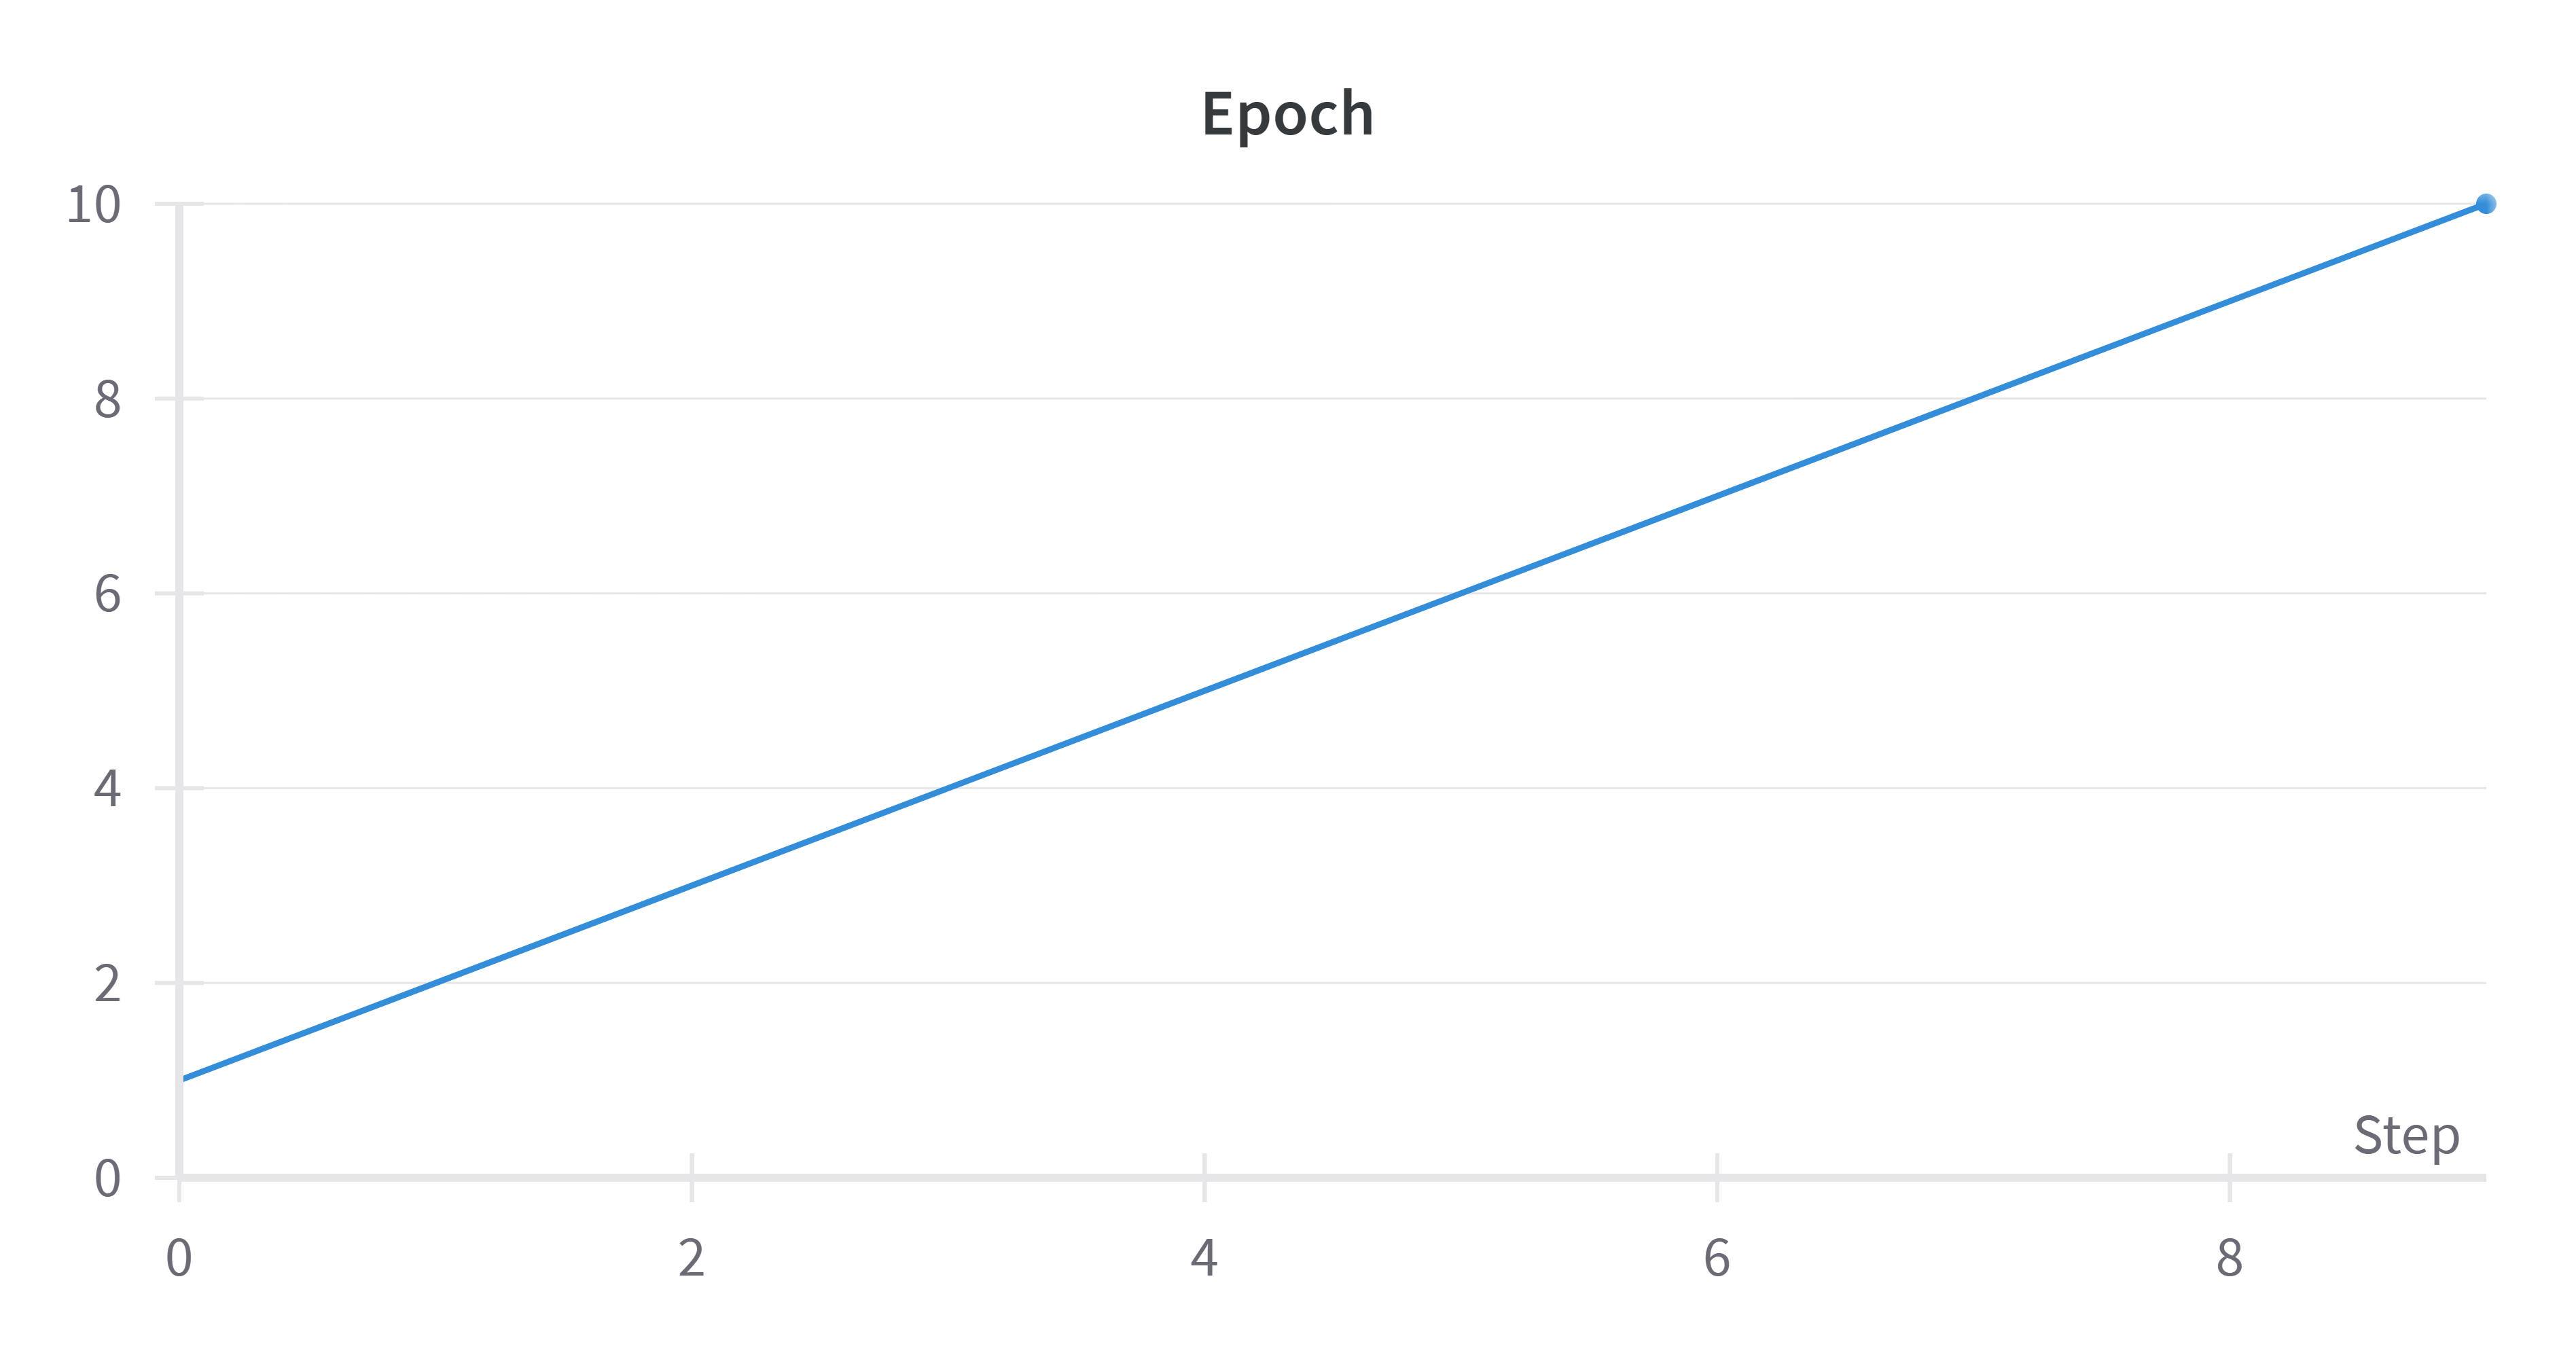

![W&B Chart 8_3_2024, 4_37_09 am.png](<attachment:W&B Chart 8_3_2024, 4_37_09 am.png>)
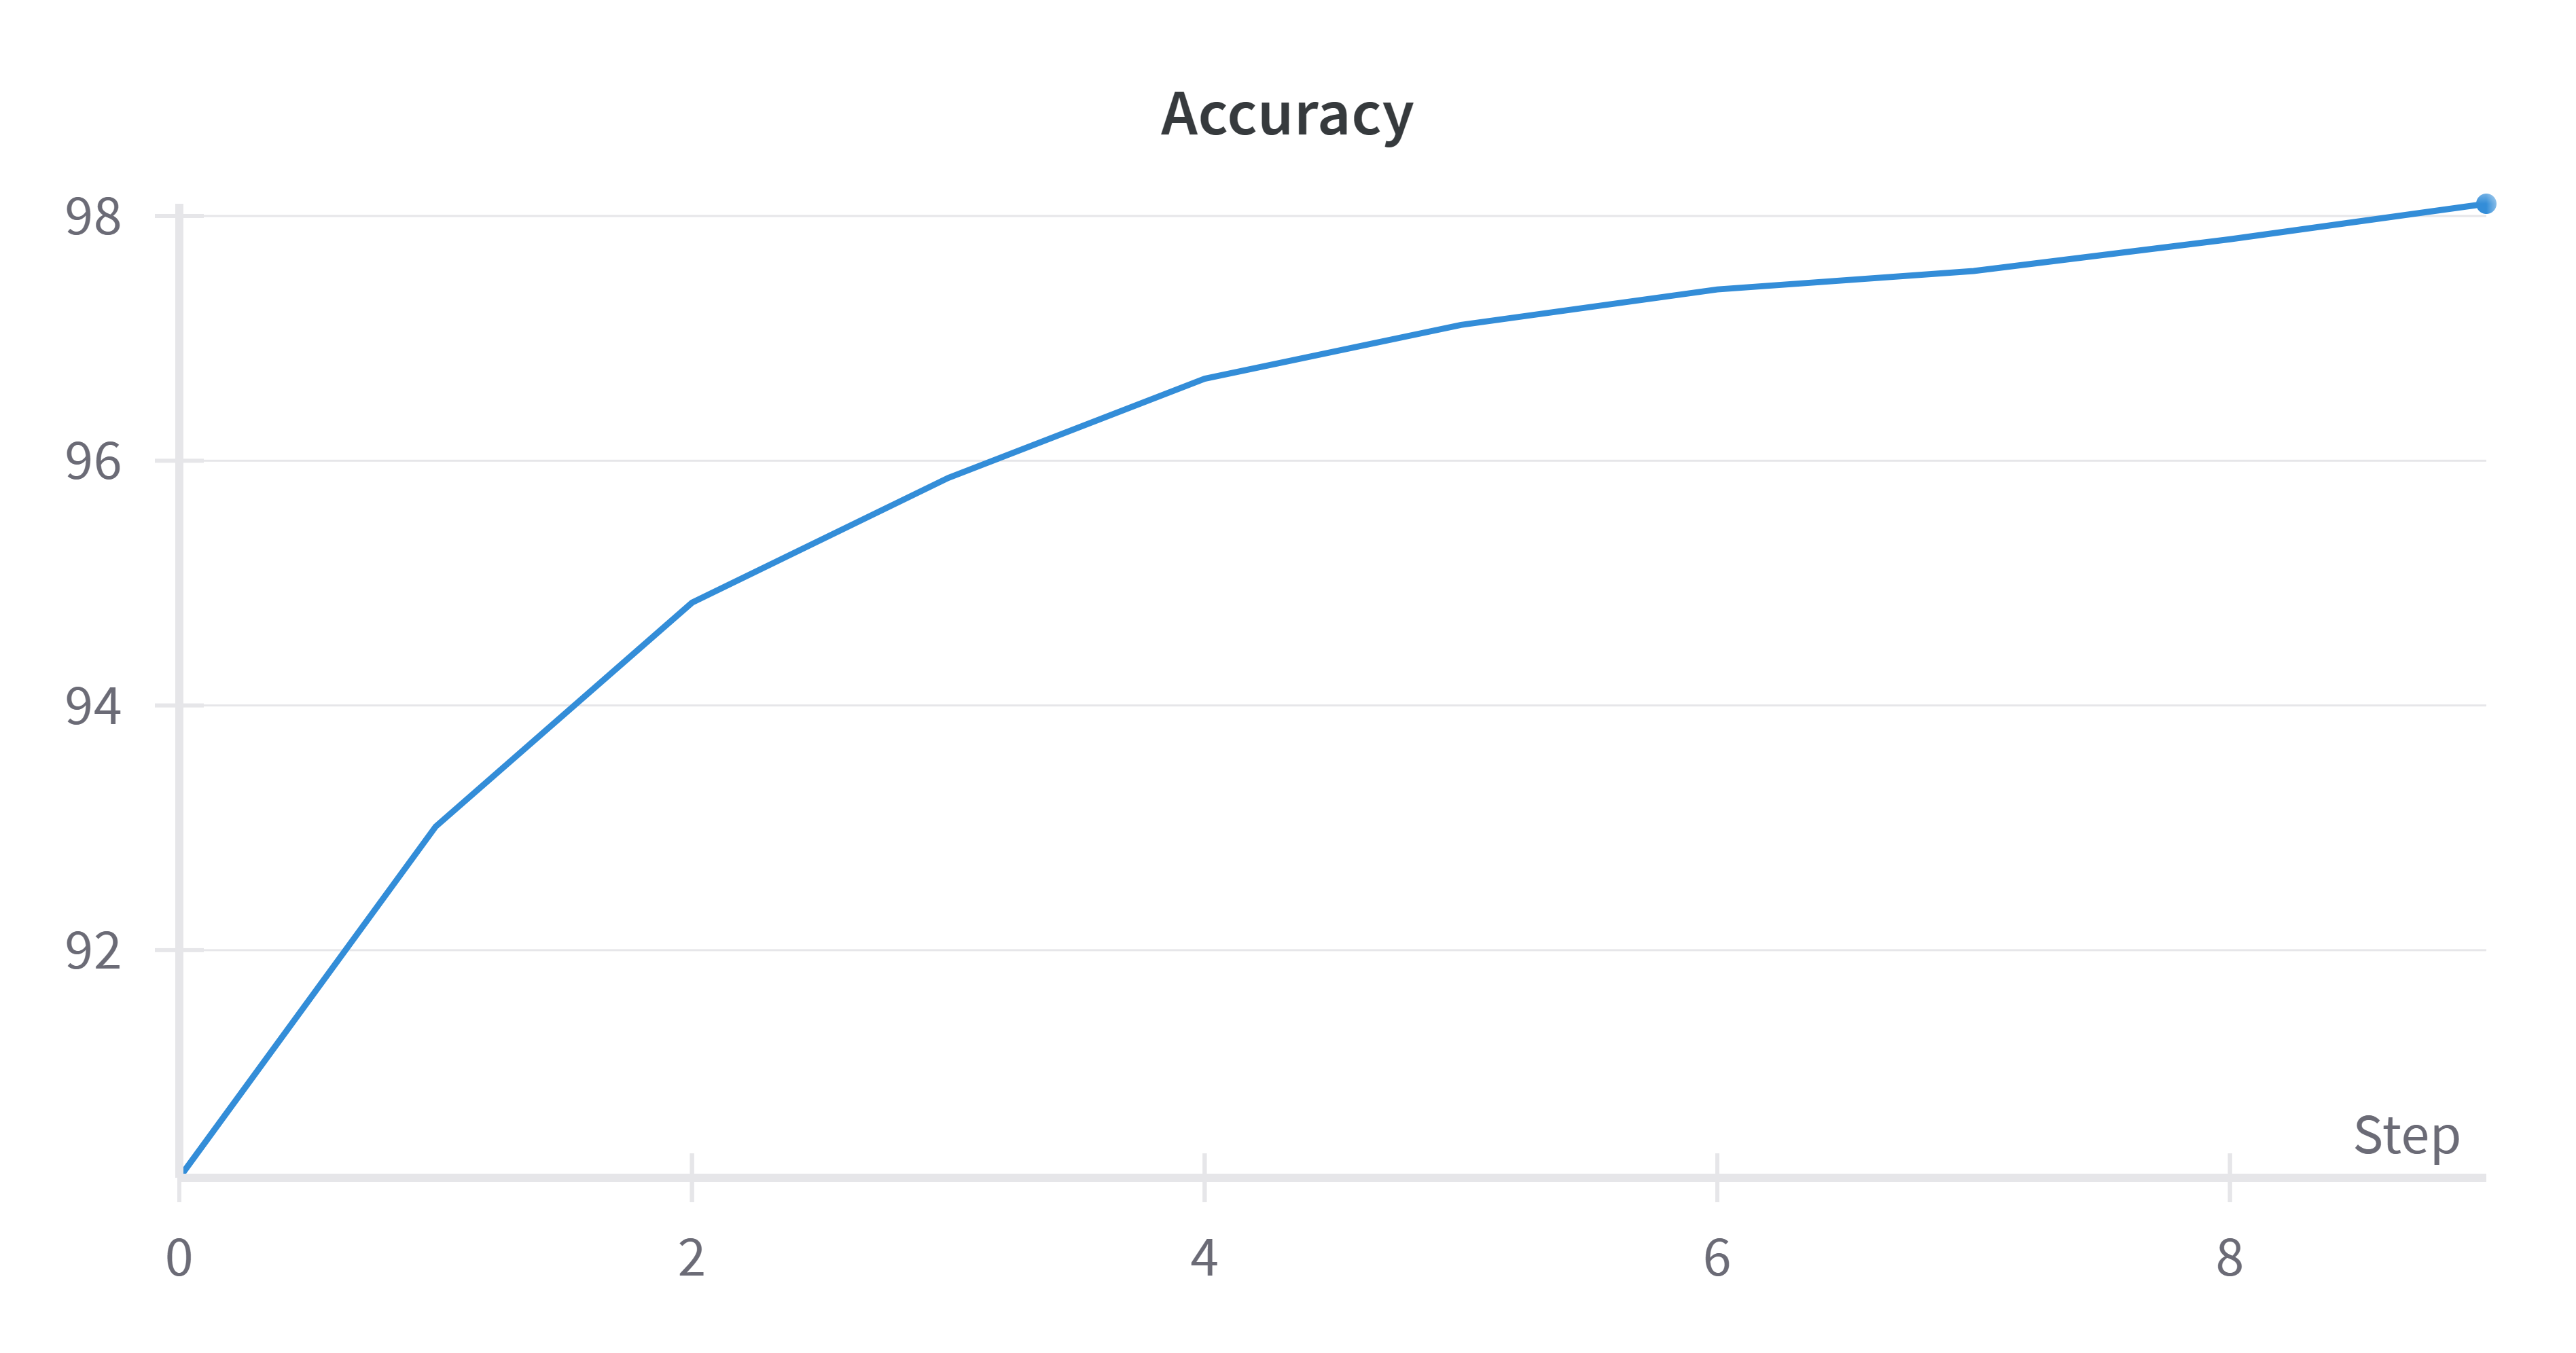

![W&B Chart 8_3_2024, 4_37_28 am.png](<attachment:W&B Chart 8_3_2024, 4_37_28 am.png>)
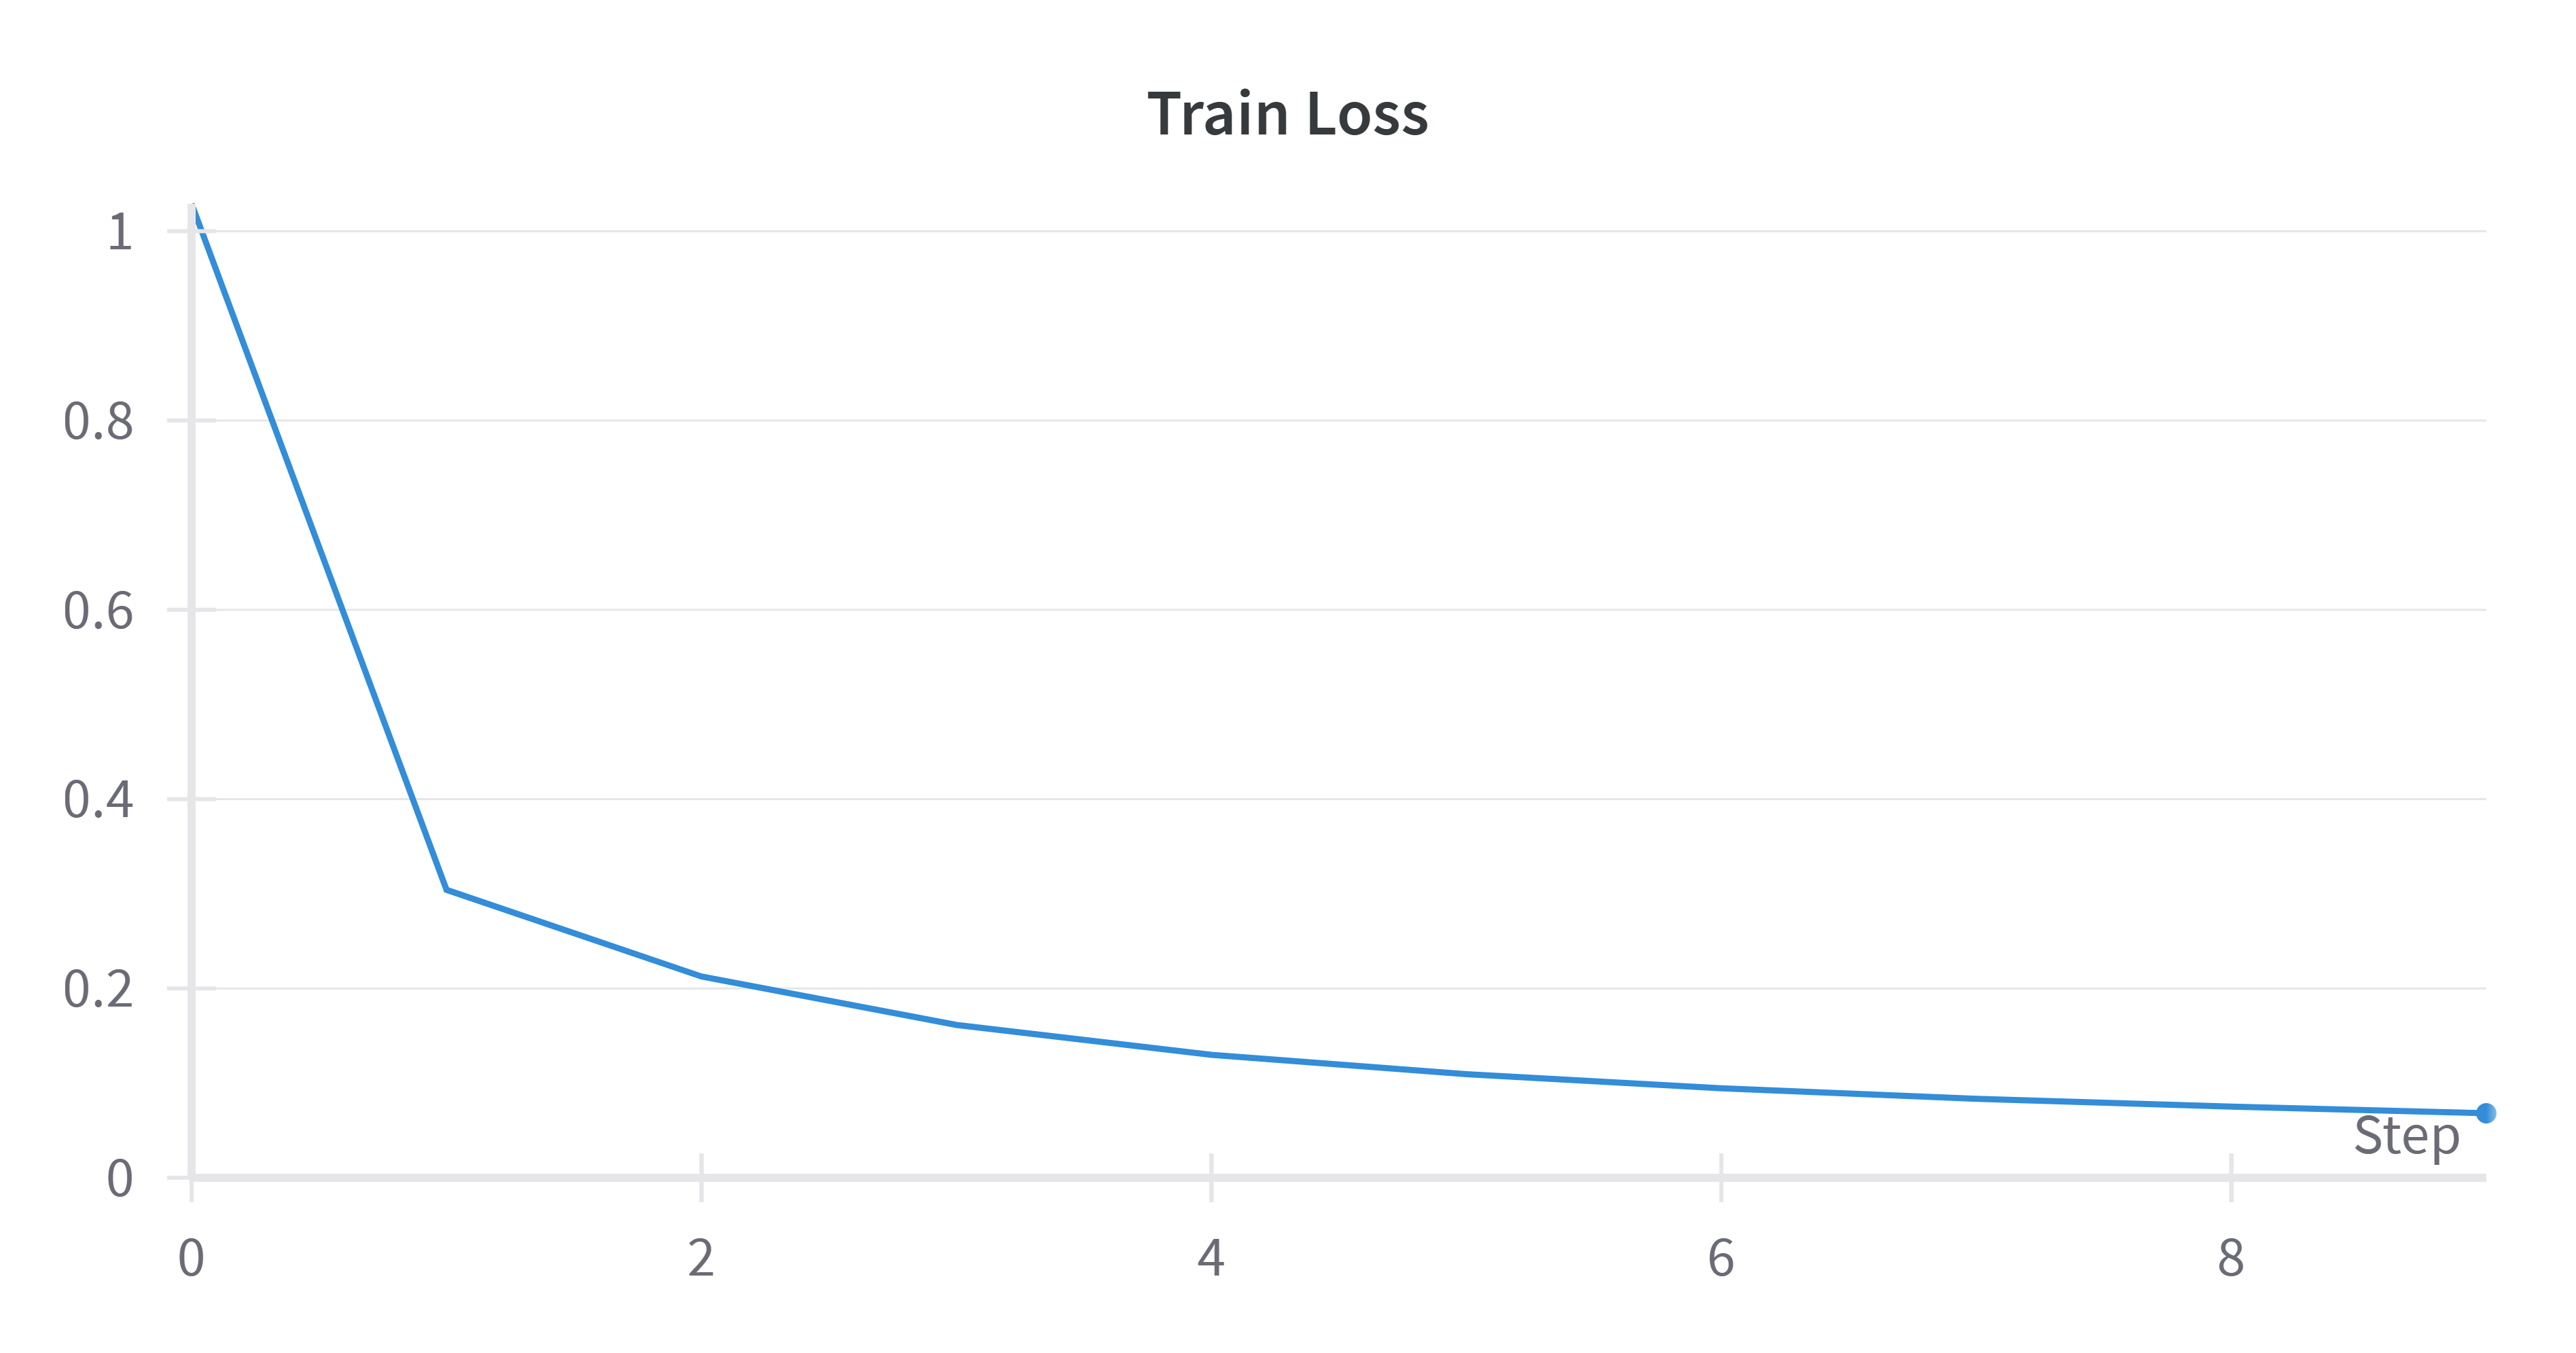

![W&B Chart 8_3_2024, 4_37_18 am.png](<attachment:W&B Chart 8_3_2024, 4_37_18 am.png>)
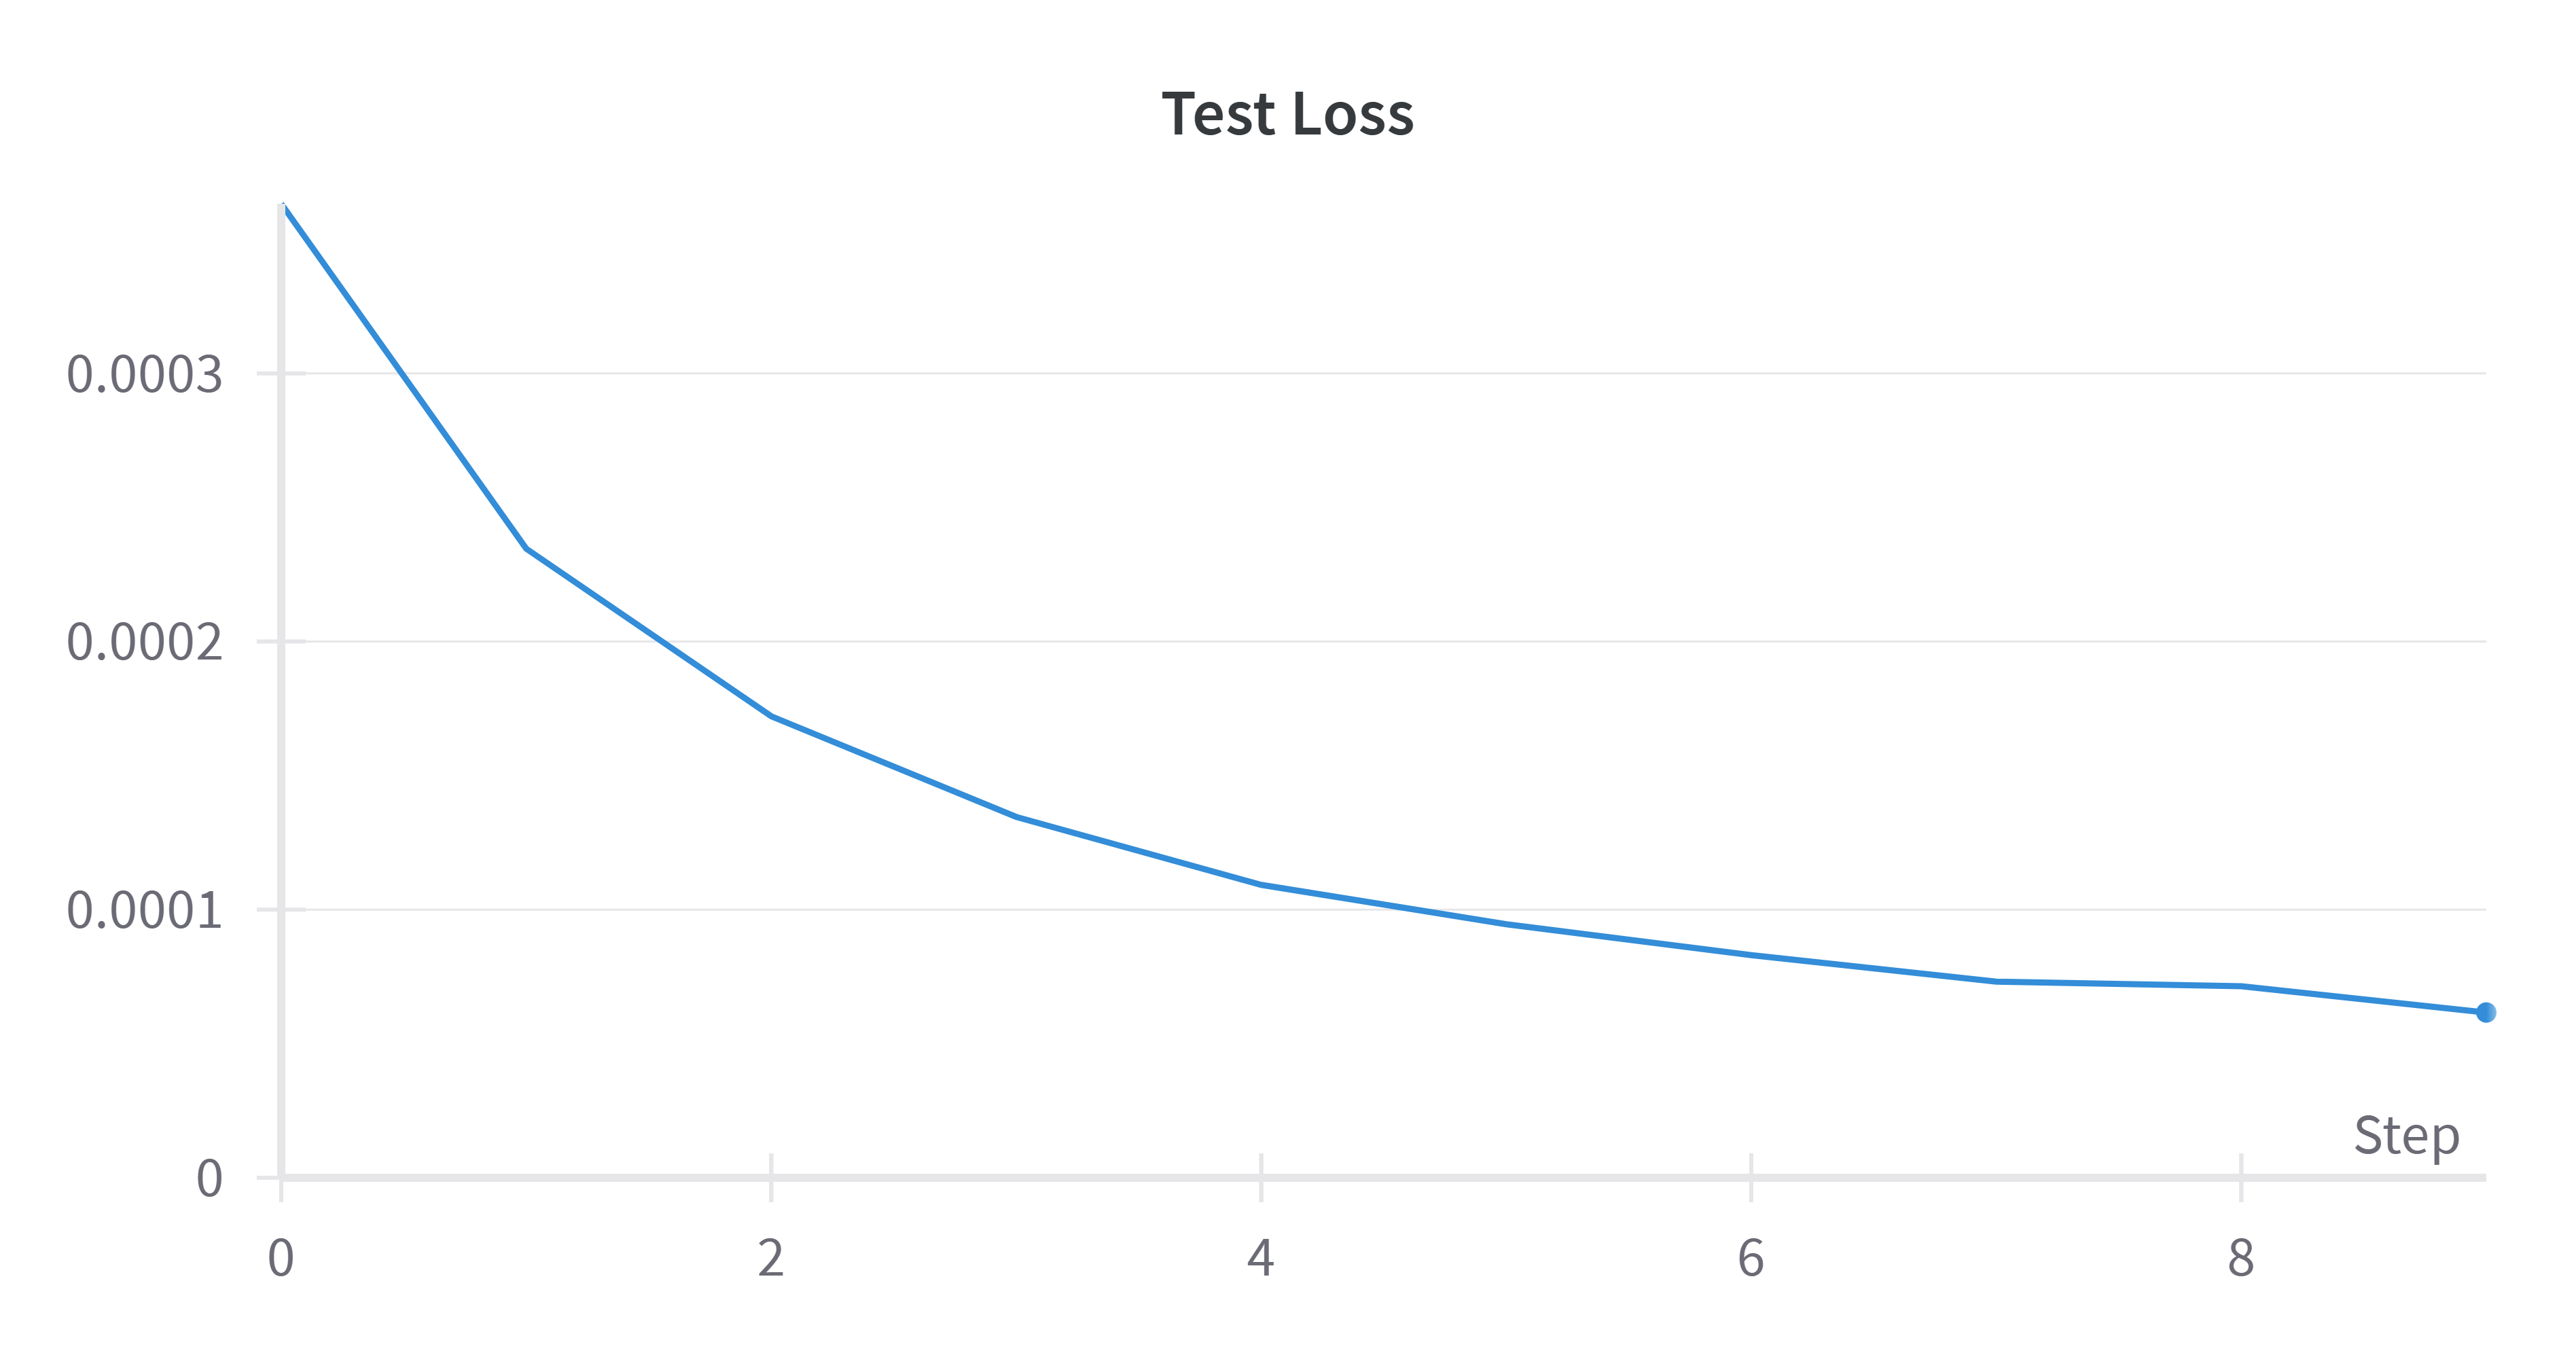

#### Hyperparameter tuning

In [482]:
batch_size = [64,512]
lr = [0.01, 0.001]
momentum = [0.5]
optimizer = [optim.SGD, optim.Adam]

accuracy2 = []
for i in range(len(batch_size)):
    for j in range(len(lr)):
        for k in range(len(momentum)):
            for l in range(len(optimizer)):
                train_batch_size = batch_size[i]
                test_batch_size = 1000
                train_loader, test_loader = data_function(train_batch_size, test_batch_size)
                model = LeNet()
                epochs = 15
                criterion = nn.CrossEntropyLoss()
                if l == 0:
                    optimizer1 = optimizer[l](model.parameters(), lr=lr[j], momentum=momentum[k])
                else:
                    optimizer1 = optimizer[l](model.parameters(), lr=lr[j])
                # optimizer1 = optimizer[l](model.parameters(), lr=lr[j], momentum=momentum[k])
                test_loss, accuracy, model = train_epoch_loop(model, train_loader, test_loader , optimizer1, criterion, epochs, log = False, p = False)
                accuracy2.append(accuracy)
                print("For batch size:", batch_size[i], "learning rate:", lr[j], "momentum:", momentum[k], "optimizer:", optimizer[l], "the accuracy is:", accuracy[-1])

For batch size: 64 learning rate: 0.01 momentum: 0.5 optimizer: <class 'torch.optim.sgd.SGD'> the accuracy is: 98.36
For batch size: 64 learning rate: 0.01 momentum: 0.5 optimizer: <class 'torch.optim.adam.Adam'> the accuracy is: 95.01
For batch size: 64 learning rate: 0.001 momentum: 0.5 optimizer: <class 'torch.optim.sgd.SGD'> the accuracy is: 91.95
For batch size: 64 learning rate: 0.001 momentum: 0.5 optimizer: <class 'torch.optim.adam.Adam'> the accuracy is: 98.71
For batch size: 512 learning rate: 0.01 momentum: 0.5 optimizer: <class 'torch.optim.sgd.SGD'> the accuracy is: 93.27
For batch size: 512 learning rate: 0.01 momentum: 0.5 optimizer: <class 'torch.optim.adam.Adam'> the accuracy is: 98.31
For batch size: 512 learning rate: 0.001 momentum: 0.5 optimizer: <class 'torch.optim.sgd.SGD'> the accuracy is: 50.75
For batch size: 512 learning rate: 0.001 momentum: 0.5 optimizer: <class 'torch.optim.adam.Adam'> the accuracy is: 98.61


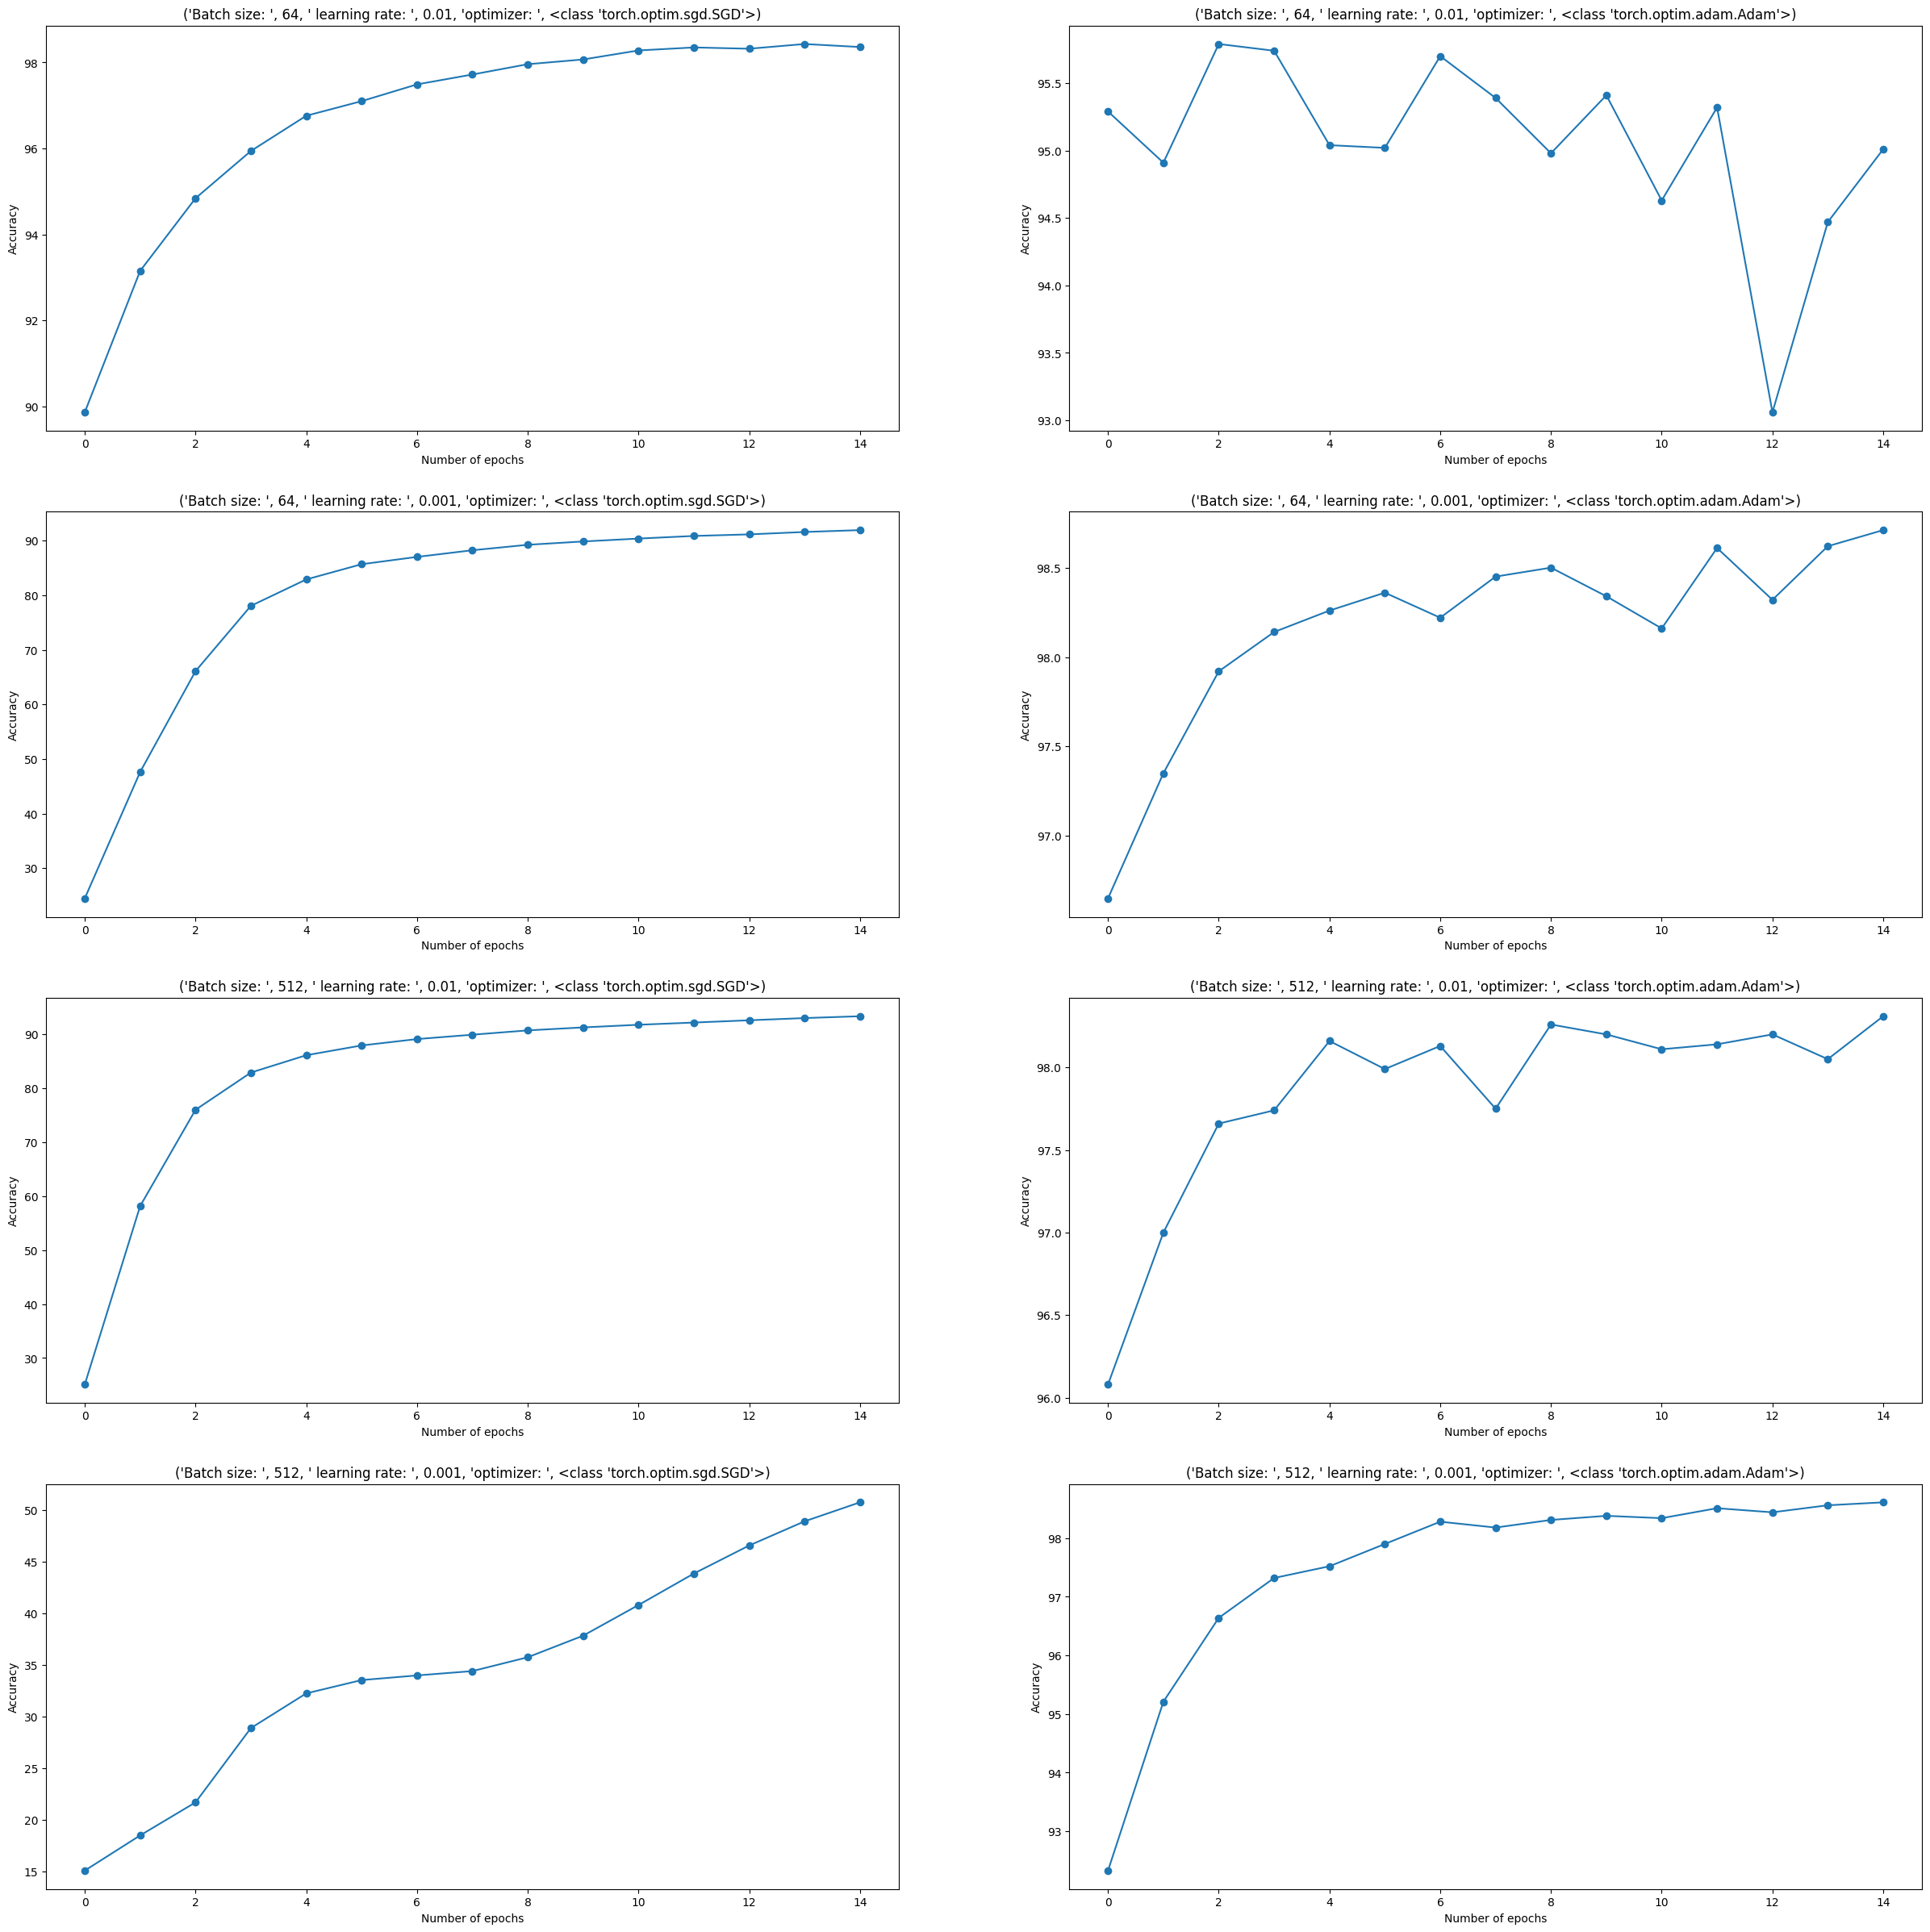

In [483]:
# making a subplot
idx=0
plt.figure(figsize=(30,30))
for i in range(len(batch_size)):
    for j in range(len(lr)):
        for k in range(len(optimizer)):
            acc3 = accuracy2[idx]
            plt.subplot(4,2,idx+1)
            plt.plot(range(epochs), acc3, '-o')
            plt.xlabel('Number of epochs')
            plt.ylabel('Accuracy')
            string = 'Batch size: ', batch_size[i] , " learning rate: " , lr[j] , "optimizer: ", optimizer[k]
            plt.title(string)
            idx = idx + 1

plt.show()

Learning rate affects the accuracy significantly.When we use Adam, a lower learning rate performs better while a higher learning rate leads to severe instability and causes a drop in accuracy. This might be due to lower learning rates offering stability and better convergenece, to which Adam can adapt. Vice versa, higher learning rate makes SGD perform better. This is due to higher learning rates allowing SGD to make bigger updates and thus escaping out of local minima.

In case of SGD, bigger batch size causes drop in accuracy, as the convergence is slower(due to smaller updates as averaged over size of batch)  and might not be able to accomplish in the given number of epochs. In case of Adam, smaller batch perform better on avergae than bigger batch.

I think optimiser is the most important parameter. Adam provies better results overall than SGD and also has the best performing model.

#### Best performing CNN vs SIFT BOVW approach

Best performing CNN has batch_size= 64, learning rate= 0.001 and Optimiser as Adam, gives accuracy 98.71
Best SIFT BoVW approach has clusters as 500, giving accuracy as 83.87.
Clearly CNN is better than SIFT BoVW, as CNN can caputure features better and is invariant to translation. There is also end-to-end learning, i.e. CNNs can optimise any step in the learning process. This is not possible in SIFT BoVW, as features are extracted, then classified.

#### Performance change when convolution layers double

In [515]:
# doubling the layers of convolution
class LeNet2(nn.Module):
    def __init__(self):
        super(LeNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) #output is 28x28x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2) #input is 14x14x16, output is 16x16x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2)  #input is 8x8x32, output is 10x10x64
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=2)  #input is 5x5x64, output is 7x7x16
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16*3*3, 120) 
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))  
        x = self.pool(x)
        x = self.activation(self.conv4(x))  
        x = self.pool(x)
        x = x.view(-1, 16*3*3)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


In [516]:
# defininf model run
def model_run(model_num):
    train_batch_size2 = 64
    test_batch_size2 = 1000
    train_loader2, test_loader2 = data_function(train_batch_size2, test_batch_size2)

    if model_num == 1:
        model2 = LeNet()
    else:
        model2 = LeNet2()
    epochs2 = 20
    criterion2 = nn.CrossEntropyLoss()
    optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
    test_loss2, accuracy2, model2 = train_epoch_loop(model2, train_loader2, test_loader2 , optimizer2, criterion2, epochs2, log = False, p = False)
    return accuracy2

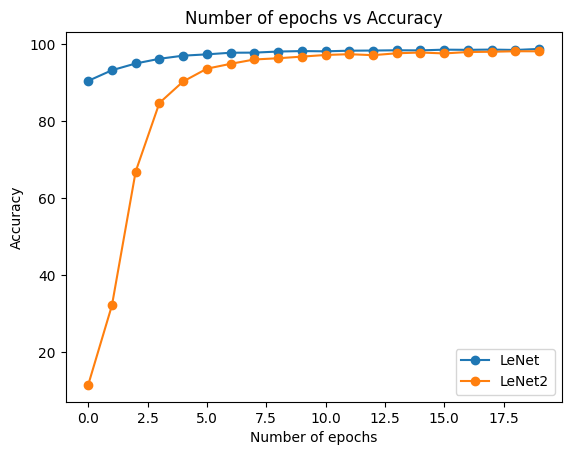

In [517]:
# comparing the 2 models
acc_model_1 = model_run(1)
acc_model_2 = model_run(2)

# plotting the graph
plt.plot(range(len(acc_model_1)), acc_model_1, '-o', label = 'LeNet')
plt.plot(range(len(acc_model_2)), acc_model_2, '-o', label = 'LeNet2')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Number of epochs vs Accuracy')
plt.legend()
plt.show()


We can see that doubling the layers of convolution, makes the model more complex and causes initial epochs to have less accuracy. With increase in epochs, it reaches same lebel of accuracy as simple CNN

#### Performance vs Training samples

In [532]:
# defining a function which modifies the train set to give back a subset with equal representation of all classes

def data_modif(train_set, total_samples):

    #iterating through the trainset to get data and store it in dictionary
    data_dict = {}

    for i in range(len(train_set)):
        tensor, label = train_set[i]
        if label in data_dict:
            data_dict[label].append(tensor)
        else:
            data_dict[label] = [tensor]
    
    num_classes = len(data_dict)    
    num_samples_per_class = total_samples / num_classes
    labels = list(data_dict.keys())

    #iterating through the dictionary and choosing randomly samples to get the subset
    subset = []
    subset_label = []
    for i in labels:
        subset = subset + data_dict[i][:int(num_samples_per_class)]
        subset_label = subset_label + [i]*int(num_samples_per_class)
    train_set_modif = list(zip(subset, subset_label))

    return train_set_modif

# defining the function for data (dataset and dataloader)
def data_function2(train_batch_size , test_batch_size, total_samples):
    # define transformation to apply to the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),  # convert to tensor
        transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
        transforms.Normalize((0.5,), (0.5,)),  # Normalize the data
    ])

    # Download and load the training set
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Download and load the test set
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_set = data_modif(train_set, total_samples)

    # defining the dataloader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

# defininf model run
def model_run3(model_num, total_samples):
    train_batch_size2 = 64
    test_batch_size2 = 1000
    train_loader2, test_loader2 = data_function2(train_batch_size2, test_batch_size2, total_samples)

    if model_num == 1:
        model2 = LeNet()
    else:
        model2 = LeNet2()
    epochs2 = 10
    criterion2 = nn.CrossEntropyLoss()
    optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
    test_loss2, accuracy2, model2 = train_epoch_loop(model2, train_loader2, test_loader2 , optimizer2, criterion2, epochs2, log = False, p = False)
    return accuracy2
    





In [534]:
total_Samples = [600,1800,6000,18000,60000]

acc_num_samples = []

for t in total_Samples:
    acc_model_1 = model_run3(1, t)
    acc_num_samples.append(acc_model_1)
    print("Model trained on" , t, "samples has accuracy of", acc_model_1[-1])

Model trained on 600 samples has accuracy of 31.59
Model trained on 1800 samples has accuracy of 73.84
Model trained on 6000 samples has accuracy of 89.67
Model trained on 18000 samples has accuracy of 94.9
Model trained on 60000 samples has accuracy of 97.57


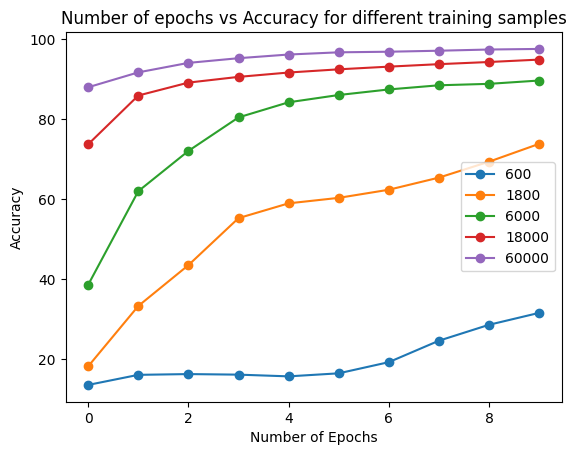

In [546]:
# plotting for different training samples
for i in range(len(total_Samples)):
    a = acc_num_samples[i]
    plt.plot(range(len(a)), a,  '-o', label = total_Samples[i])
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title('Number of epochs vs Accuracy for different training samples')
plt.legend()
plt.show()


We can see that the accuracy increases with increase in number of training samples. This is correct as with more training samples, the model can learn better features and generalise well. As more training samples gives more features, the model misses out on less features too.

#### Transformers (ViT)

In [614]:
# defining class of transformers
class Transformer(nn.Module):
    def __init__(self, input_dim, patch_dim , hidden_dim, num_layers, num_heads, output_dim):
        super(Transformer,self).__init__()
        num_patches = (input_dim // patch_dim) 
        self.patch_embedding = nn.Conv2d(1, hidden_dim, kernel_size=patch_dim, stride=patch_dim)  
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, num_patches, hidden_dim))  
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads), num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.patch_embedding(x)  # Shape: (batch_size, hidden_dim, num_patches_h, num_patches_w)
        batch_size, hidden_dim, num_patches_h, num_patches_w = x.size()
        x = x + self.pos_embedding[:, :num_patches_h ,:num_patches_w].permute(0, 3, 1, 2)  # Shape: (batch_size, hidden_dim, num_patches_h, num_patches_w)
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1)
        x = self.fc(x)  # Shape: (batch_size, output_dim)

        return x

In [615]:
# defininf model run
def model_run4(model_num, total_samples):
    train_batch_size2 = 64
    test_batch_size2 = 1000
    train_loader2, test_loader2 = data_function2(train_batch_size2, test_batch_size2, total_samples)

    model2 = Transformer(28, 7, 64, 2, 2, 10)
    epochs2 = 10
    criterion2 = nn.CrossEntropyLoss()
    optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
    test_loss2, accuracy2, model2 = train_epoch_loop(model2, train_loader2, test_loader2 , optimizer2, criterion2, epochs2, log = False, p = False)
    return accuracy2
    

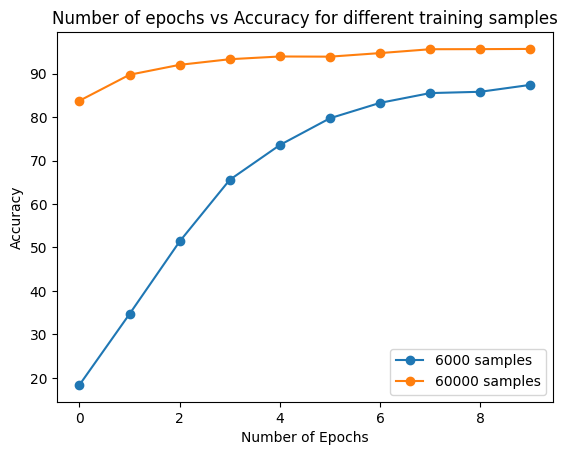

In [616]:
# running on samples
acc_6k = model_run4(1, 6000)
acc_60k = model_run4(1, 60000)

# plotting for different training samples
plt.plot(range(len(acc_6k)), acc_6k,  '-o', label = '6000 samples')
plt.plot(range(len(acc_60k)), acc_60k,  '-o', label = '60000 samples')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title('Number of epochs vs Accuracy for different training samples')
plt.legend()
plt.show()

In [617]:
print("The accuracies for 6000 samples and 60000 samples are:", acc_6k[-1], acc_60k[-1])

The accuracies for 6000 samples and 60000 samples are: 87.4 95.67


When we compare against CNN, we see a similar performance (there is a slight decrease in accuracy). This might be due to CNNs performing better on smaller datasets as they learn hierarchial spatial representation while Transformers require larger datasets.

#### Challenges
1. torch and torchvision are new libraries for me. So faced an issue in using them.
2. The training took long time so had to be cautious during hyperparameter tuning.
3. Faced issue with pipelining of BoVM approach at start.